## Comparación Modelos: Regresión

### Carga de Datos

Importamos las librerías necesarias y los datos para poder comparar diferentes modelos sobre un mismo problema de regresión. En este caso el problema consiste en estimar el precio de un coche dada una serie de características del mismo (desde el fabricante hasta el tipo de combustible). Es un dataset sencillo para que los modelos no tarden en entrenarse, pero dado el escaso número de instancias no es el mejor ejemplo para aplicar determinados algoritmos que tienden a sobreajustarse con pocos datos.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler


In [2]:
df = pd.read_csv("./data/auto_prices.csv")

In [3]:
df.head()

,fuel_type,num_doors,body_style,wheel_base,engine_size,bore,stroke,horsepower,peak_rpm,city_mpg,...,make_mitsubishi,make_nissan,make_peugot,make_plymouth,make_porsche,make_saab,make_subaru,make_toyota,make_volkswagen,make_volvo
0,0.0,2,0.0,88.6,130,3.47,2.68,111,5000,21,...,0,0,0,0,0,0,0,0,0,0
1,0.0,2,0.0,88.6,130,3.47,2.68,111,5000,21,...,0,0,0,0,0,0,0,0,0,0
2,0.0,2,1.0,94.5,152,2.68,3.47,154,5000,19,...,0,0,0,0,0,0,0,0,0,0
3,0.0,4,2.0,99.8,109,3.19,3.40,102,5500,24,...,0,0,0,0,0,0,0,0,0,0
4,0.0,4,2.0,99.4,136,3.19,3.40,115,5500,18,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193 entries, 0 to 192
Data columns (total 33 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   fuel_type           193 non-null    float64
 1   num_doors           193 non-null    int64  
 2   body_style          193 non-null    float64
 3   wheel_base          193 non-null    float64
 4   engine_size         193 non-null    int64  
 5   bore                193 non-null    float64
 6   stroke              193 non-null    float64
 7   horsepower          193 non-null    int64  
 8   peak_rpm            193 non-null    int64  
 9   city_mpg            193 non-null    int64  
 10  highway_mpg         193 non-null    int64  
 11  price               193 non-null    int64  
 12  make_alfa-romero    193 non-null    int64  
 13  make_audi           193 non-null    int64  
 14  make_bmw            193 non-null    int64  
 15  make_chevrolet      193 non-null    int64  
 16  make_dod

In [5]:
target = "price"

<Axes: xlabel='price', ylabel='Count'>

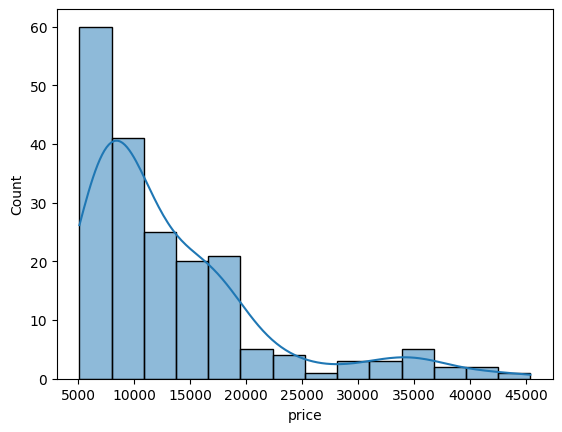

In [6]:
sns.histplot(x= "price", data = df, kde = True)

Es un dataset limpio y preparado al que únicamente tendremos que escalar las variables para los modelos sensibles a dicha escala en nuestro caso la regresión lineal. Además el target está topado porque hay un precio mínimo (quizás sería intersante hacer un modelo contra el logaritmo del target y luego transformalo de vuelta)

In [7]:
train_set, test_set = train_test_split(df, test_size= 0.2, random_state= 42)

Por sencillez, no vamos a transformar las variables, sólo vamos a escalarlas, deberíamos hacer un pequeño estudio de cada potencial feature y ver que transformación/escalado es el más adecuado...

In [8]:
features = train_set.columns.to_list()
features.remove(target)
scaler = StandardScaler()
X_train = train_set[features]
y_train = train_set[target]
y_log_train = train_set[target].apply(np.log)
X_test = test_set[features]
y_test = test_set[target]
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns= features)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns = features)

### Modelos

Vamos a escoger todos los modelos que hemos visto de regresión y los vamos a probar todos:

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

model_names = ["Regresion Lineal","DecisionTree","Random Forest","XGBoost","LightGBM","CatBoost"]
lr_clf = LinearRegression()
tree_clf = DecisionTreeRegressor(random_state= 42)
rf_clf = RandomForestRegressor(random_state= 42)
xgb_clf = XGBRegressor(random_state = 42)
lgb_clf = LGBMRegressor(random_state= 42, verbose = -100)
cat_clf = CatBoostRegressor(random_state= 42, verbose = False)

model_set = [lr_clf, tree_clf, rf_clf, xgb_clf, lgb_clf, cat_clf]


### Comparación con Validación Cruzada (pre-optimización)


In [10]:
metricas_cv = {}
valores = []
for nombre,modelo in zip(model_names, model_set):
    print(modelo)
    if nombre == "Regresion Lineal":
        metricas_cv[nombre] = cross_val_score(modelo, X_train_scaled, y_train, cv = 3, scoring = "neg_mean_squared_error")
    else:
        metricas_cv[nombre] = cross_val_score(modelo, X_train, y_train, cv = 3, scoring = "neg_mean_squared_error")
    valores.append(np.mean(metricas_cv[nombre]))
ganador = list(metricas_cv.keys())[np.argmax(valores)]

LinearRegression()
DecisionTreeRegressor(random_state=42)
RandomForestRegressor(random_state=42)
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)
LGBMRegressor(random_state=42, verbose=-100)


In [11]:
for model_name, valores in metricas_cv.items():
    print(f"Model <{model_name}>, RMSE_CV: {np.sqrt(-np.mean(valores))}")
print(f"El ganador es {ganador}")

Model <Regresion Lineal>, RMSE_CV: 2687.814705024132
Model <DecisionTree>, RMSE_CV: 3332.2421904449325
Model <Random Forest>, RMSE_CV: 2589.5047373415387
Model <XGBoost>, RMSE_CV: 2900.5140359162247
Model <LightGBM>, RMSE_CV: 3837.6938192970165
Model <CatBoost>, RMSE_CV: 3251.0555613918264
El ganador es Random Forest


### Optimizacion del Ganador


In [12]:

params_grid = {
    "n_estimators": [100,200,400],
    "max_depth": [2,4,10],
    #"min_samples_leaf": [10,20,40],
    "max_features": ["sqrt","log2",None],
    "max_samples": [0.3,0.6,1]
}

rf_grid = GridSearchCV(rf_clf,
                       param_grid= params_grid,
                       cv = 5,
                       scoring = "neg_mean_squared_error",
                       n_jobs = -1)

rf_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [2, 4, 10],
                         'max_features': ['sqrt', 'log2', None],
                         'max_samples': [0.3, 0.6, 1],
                         'n_estimators': [100, 200, 400]},
             scoring='neg_mean_squared_error')

In [13]:
np.sqrt(-rf_grid.best_score_)

np.float64(2473.553103854178)

In [14]:
rf_grid.best_params_

{'max_depth': 10,
 'max_features': None,
 'max_samples': 0.6,
 'n_estimators': 400}

In [15]:
y_pred = rf_grid.best_estimator_.predict(X_test)
print("MAE:", mean_absolute_error(y_test,y_pred))
print("MAPE:", mean_absolute_percentage_error(y_test,y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

MAE: 1490.3303366809478
MAPE: 0.095288118211499
RMSE: 2609.4773942960474


### Comparación con Optimización previa

Una alternativa a hacer una validación cruzada sin optimizar es hacer una comparativa de modelos semi-optimizados mediante una estrategia de RandomSearch.  
La idea es combinar la capacidad de comparativa de la validación cruzada pero haciendo que los modelos puedan aprovechar relativamente un poco de optimización de hiperparámetros y no hacerlo a la primera con cada uno.


In [16]:
metricas_optimizadas = {}

In [17]:
### Linear Regresion
from sklearn.linear_model import ElasticNet

param_grid = {
    "alpha": [0.1, 1, 10, 100],
    "l1_ratio": [0.2,0.4,0.6,1]

} 
model = ElasticNet()
lr_grid = RandomizedSearchCV( model,
                             cv = 3, 
                             n_iter = 20,
                             param_distributions= param_grid,
                             scoring= "neg_mean_squared_error"
)

lr_grid.fit(X_train_scaled,y_train)
print("LR best_score:", np.sqrt(-lr_grid.best_score_))
metricas_optimizadas["Linear Regresion"] = np.sqrt(-lr_grid.best_score_)

LR best_score: 2581.409088678897


h:\RepoBootcamp\RepoEjercicios\venv\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 16 is smaller than n_iter=20. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
h:\RepoBootcamp\RepoEjercicios\venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.825e+06, tolerance: 6.010e+05
  model = cd_fast.enet_coordinate_descent(
h:\RepoBootcamp\RepoEjercicios\venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.330e+06, tolerance: 4.616e+05
  model = cd_fast.enet_coordinate_descent(
h:\RepoBootcamp\RepoEjer

In [18]:
### DecisionTrees

tree_clf = DecisionTreeRegressor()

param_grid = {
    "max_depth": [1,2,4,8,None],
    "min_samples_leaf": [1,5,10,20],
    "max_features": ["sqrt","log2", None]
}

tree_grid = RandomizedSearchCV(tree_clf, 
                               cv = 3,
                               n_iter = 20,
                               param_distributions= param_grid, 
                               scoring = "neg_mean_squared_error")

tree_grid.fit(X_train,y_train)
print("Tree best_score:", np.sqrt(-tree_grid.best_score_))
metricas_optimizadas["Tree"] = np.sqrt(-tree_grid.best_score_)

Tree best_score: 3001.0563696172385


In [19]:
### RandomForest

rf_clf = RandomForestRegressor()

params_grid = {
    "n_estimators": [100,200,400],
    "max_depth": [2,4,10],
    "max_features": ["sqrt","log2",None],
    "max_samples": [0.3,0.6,1]
}

rf_grid = RandomizedSearchCV(rf_clf, 
                               cv = 3,
                               n_iter = 20,
                               param_distributions= param_grid, 
                               scoring = "neg_mean_squared_error")


rf_grid.fit(X_train, y_train)
print("RF best_score:", np.sqrt(-rf_grid.best_score_))
metricas_optimizadas["RandomForest"] = np.sqrt(-rf_grid.best_score_)

RF best_score: 2579.199587803457


In [20]:
### XGBoost

xgb_clf = XGBRegressor()

param_grid = {'max_depth': [3, 6, 10, 15],
          'learning_rate': [0.2, 0.6, 0.9],
          'subsample': np.arange(0.5, 1.0, 0.1),
          'colsample_bytree': np.arange(0.5, 1.0, 0.1),
          'colsample_bylevel': np.arange(0.5, 1.0, 0.1),
          'n_estimators': [100, 250, 500, 750],
          }

xgb_grid = RandomizedSearchCV(xgb_clf, 
                               cv = 3,
                               n_iter = 20,
                               param_distributions= param_grid, 
                               scoring = "neg_mean_squared_error")


xgb_grid.fit(X_train, y_train)
print("XGB best_score:", np.sqrt(-xgb_grid.best_score_))
metricas_optimizadas["XGBoost"] = np.sqrt(-xgb_grid.best_score_)

XGB best_score: 2389.2999017840325


In [21]:
### LightGBM 


lgb_clf = LGBMRegressor(verbose = -100)

param_grid= {'max_depth': [3, 6, 12],
          'learning_rate': [0.1, 0.2, 0.3, 0.4],
          'bagging_fraction': [0.3,0.6,1],
          'feature_fraction': [0.5,1],
          'n_estimators': [100, 250, 500, 750],
          'max_bins': [125,250]
          }

lgb_grid = RandomizedSearchCV(lgb_clf, 
                               cv = 3,
                               n_iter = 20,
                               param_distributions= param_grid, 
                               scoring = "neg_mean_squared_error")


lgb_grid.fit(X_train, y_train)
print("LGB best_score:", np.sqrt(-lgb_grid.best_score_))
metricas_optimizadas["LightGBM"] = np.sqrt(-lgb_grid.best_score_)

LGB best_score: 3483.479136154574


In [22]:
### CatBoost

cat_clf = CatBoostRegressor(verbose = False)

param_grid= {'depth': [3, 6, 12],
          'learning_rate': [0.1, 0.2, 0.3, 0.4],
          #'bagging_fraction': [0.3,0.6,1], No hay hiperparámetro equivalente
          'colsample_bylevel': [0.5,1],
          'iterations': [100, 250, 500, 750],
          "border_count": [125,250]
          }


cat_grid = RandomizedSearchCV(cat_clf, 
                               cv = 3,
                               n_iter = 3,
                               param_distributions= param_grid, 
                               scoring = "neg_mean_squared_error")


cat_grid.fit(X_train, y_train)
print("CatBoost best_score:", np.sqrt(-cat_grid.best_score_))
metricas_optimizadas["CatBoost"] = np.sqrt(-cat_grid.best_score_)

CatBoost best_score: 2960.799962563368
